Implementation of the various methods introduced in the paper "High-dimensional vector autoregressive time series modeling via tensor decomposition" by Di Wang, Yao Zheng, Heng Lian and Guodong Li.

The two algorithms are implemented but only the first has been tested on real data. The dataset comes from Kaggle ($\href{https://www.kaggle.com/code/sayakchakraborty/air-quality-prediction-of-relative-humidity}{Air Quality prediction of Relative Humidity}$). It seems the implementation is faulty and does not work, but we failed to find where the error was.

Some implementations of the operations would need to be reworked as they are done with loops and do not benefit from vectorization. We tried to write extensive comments of what is happening to help link the code with the paper.

# SETUP

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


# Operations on tensors

In [ ]:
#we write our custom matricization function
#we want it to be differentiable with pytorch so we use pytorch operations
def matricization(A, mode):
    """
    Computes the matricization of tensor A.

    Parameters
    ----------
    A : torch tensor
        tensor for which the matricization is desired
    mode : int
        the possible modes are 1, 2 and 3

    Returns
    -------
        M: matricization of the tensor
    """

    if mode == 1:
        return torch.cat([A.select(2, i) for i in range(A.size(2))], dim=1)

    elif mode == 2:
        return torch.cat([A.select(2, i).T for i in range(A.size(2))], dim=1)

    elif mode == 3:
        return torch.vstack([A.select(2, i).T.reshape(-1) for i in range(A.size(2))])


    """ equivalent to the following :
    p1, p2, p3 = A.shape
    if mode == 1:
        res = torch.zeros(p1, p2 * p3)
        for i in range(p1):
            for j in range(p2):
                for k in range(p3):
                    res[i, k * p2 + j] = A[i, j, k]
    elif mode == 2:
        res = torch.zeros(p2, p1 * p3)
        for i in range(p1):
            for j in range(p2):
                for k in range(p3):
                    res[j, k * p1 + i] = A[i, j, k]
    elif mode == 3:
        res = torch.zeros(p3, p1 * p2)
        for i in range(p1):
            for j in range(p2):
                for k in range(p3):
                    res[k, j * p1 + i] = A[i, j, k]
    return res """

In [ ]:
#test matricization with the examples in the Kolda and Bader paper
A = torch.zeros(3, 4, 2)
A[:, :, 0] = torch.arange(1, 13).reshape(4, 3).transpose(0, 1)
A[:, :, 1] = torch.arange(13, 25).reshape(4, 3).transpose(0, 1)

print(A)
A1 = matricization(A, 1)
A2 = matricization(A, 2)
A3 = matricization(A, 3)

print('Matricization along mode-1:\n', A1)
print('Matricization along mode-2:\n', A2)
print('Matricization along mode-3:\n', A3)

tensor([[[ 1., 13.],
         [ 4., 16.],
         [ 7., 19.],
         [10., 22.]],

        [[ 2., 14.],
         [ 5., 17.],
         [ 8., 20.],
         [11., 23.]],

        [[ 3., 15.],
         [ 6., 18.],
         [ 9., 21.],
         [12., 24.]]])
Matricization along mode-1:
 tensor([[ 1.,  4.,  7., 10., 13., 16., 19., 22.],
        [ 2.,  5.,  8., 11., 14., 17., 20., 23.],
        [ 3.,  6.,  9., 12., 15., 18., 21., 24.]])
Matricization along mode-2:
 tensor([[ 1.,  2.,  3., 13., 14., 15.],
        [ 4.,  5.,  6., 16., 17., 18.],
        [ 7.,  8.,  9., 19., 20., 21.],
        [10., 11., 12., 22., 23., 24.]])
Matricization along mode-3:
 tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
        [13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]])


# Inverse matricization operation, only for mode 1

In [ ]:
def inv_matricization(A, p1, p2, p3):
    """
    Invert the matricization process.

    Parameters
    ----------
    A : torch 2-dimensional tensor
        the matricization for which we want to obtain the original tensor
    p1, p2, p3 : int
        ranks of the final tensor

    Returns
    -------
        T: (p1 x p2 x p3)-dimensional torch tensor for which A is a matricization
    """

    res = torch.zeros(p1, p2, p3)
    for i in range(p1):
        for j in range(p2):
            for k in range(p3):
                res[i, j, k] = A[i, k * p2 + j]
    return res

In [ ]:
def generate_A(N, P, diagonal, r1, r2, r3):
    """
    Generate a random tensor with ranks (r1, r2, r3) representing a stable AR process (all eigenvalues in the unit circle).

    Parameters
    ----------
    N : int
        dimension of the time series y_t
    P : int
        length of the AR process (ie the number of terms in the recursive formula)
    diagonal : numpy array
        array of length 3 specifying the wanted enforced eigenvalues for the problem
    r1, r2, r3 : int
        wanted ranks for the final tensor

    Returns
    -------
        A: tensor of ranks (r1, r2, r3) representing the AR process
    """

    G = torch.zeros(r1, r2, r3)
    G[0, 0, 0] = diagonal[0]
    G[1, 1, 1] = diagonal[1]
    G[2, 2, 2] = diagonal[2]

    #we generate matrices until we have a stable model, according to assumption 1 in the paper
    while True:
        O1 = torch.randn(N, r1)
        O2 = torch.randn(N, r2)
        O3 = torch.randn(P, r3)

        #generate Ui as the top ri singular vectors of the matrix
        U1 = torch.linalg.svd(O1)[0][:, :r1]
        U2 = torch.linalg.svd(O2)[0][:, :r2]
        U3 = torch.linalg.svd(O3)[0][:, :r3]


        #build A, given its tucker decomposition above
        #mode 1 product of U1 and G
        A1 = torch.einsum('ij, jkl -> ikl', U1, G)
        #mode 2 product of A1 and U2
        A2 = torch.einsum('ij, kjl -> kil', U2, A1)
        #mode 3 product of A2 and U3
        A = torch.einsum('ij, klj -> kli', U3, A2)

        #check if the model is stable by
        # Computing the companion matrix
        C = torch.zeros(N*P, N*P)
        for i in range(P):
            C[:N, i*N:(i+1)*N] = A[:, :, i]
        for i in range(P-1):
            C[(i+1)*N:(i+2)*N, i*N:(i+1)*N] = torch.eye(N)

        # Compute the eigenvalues of the companion matrix
        eigenvalues = torch.linalg.eigvals(C)
        # Check if all eigenvalues are inside the unit circle
        if torch.all(torch.abs(eigenvalues) < 1):
            #print('The model is stable')
            return A

In [ ]:
def var_generate(A, T=100):
    """
    Generate a random time series from the AR process. Used to check the quality of the various estimators.

    Parameters
    ----------
    A : torch 3-dimensional tensor
        tensor representing the AR process
    T : int
        number of samples

    Returns
    -------
        y: (N x T) dimensional matrix representing the generated samples
        x: (T x N*P) concatenations of the P previous samples along an axis
    """

    #A is a (N, N, P) tensor
    N, P = A.shape[0], A.shape[2]

    #let's matricize A to use the model in (3)
    Ac = matricization(A, 1)

    #we return x, a (T, NP) tensor
    x = torch.zeros(T, N*P)
    x[0, :] = torch.randn(N*P)

    #we also return y, a (T, N) tensor
    y = torch.zeros(T, N)
    for t in range(T):
        y[t, :] = Ac @ x[t] + torch.randn(N)
        if t < T-1:
            x[t+1, :N] = y[t, :]
            x[t+1, N:] = x[t, :-N]

    return x, y

In [ ]:
#data generation
N, P = 10, 5
r1, r2, r3 = 3, 3, 3
diagonal_list = [(2, 2, 2), (4, 3, 2), (1, 1, 1), (2, 1, 0.5)]

#let's construct the transitions matrices as built in the paper
A_list = []
for diagonal in diagonal_list:
    A_list.append(generate_A(N, P, diagonal, r1, r2, r3))

# Initial estimator

In [ ]:
def initial_estimator(x, y, lambd=0.1, max_iter=100):
    """
    Compute an estimate of A by the minimization of the mean-squared error regularized by the nuclear norm.

    Parameters
    ----------
    x : torch tensor
        concatenations of the P previous samples

    y : torch tensor
        samples of the time series

    lambd : float
        regularization parameter

    max_iter : int
        number of steps in the optimization process

    Returns
    -------
        A: estimated tensor representing the AR process
    """

    T, N = y.shape
    P = x.shape[1]//N
    #define the loss function as in the paper
    def loss(A):
        #A is of shape (N, NP)
        return (1/T)*torch.sum((y.T - A @ x.T)**2) + lambd * torch.norm(A, p='nuc')

    #we use the gradient descent algorithm to minimize the loss function
    A = torch.randn(N, N*P, requires_grad=True)
    optimizer = torch.optim.Adam([A], lr=1)

    #move A to device
    A = A

    #move the optimizer to device
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v

    #We use SGD to compute the argmin of the loss function
    for i in range(max_iter):
        l = loss(A)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()

    return A.detach()

In [ ]:
#test the initial estimator on the first transition matrix
x, y = var_generate(A_list[0], T=100)
A = initial_estimator(x, y, lambd=0.7, max_iter=1000)

#print the Frobenius norm of the error between the initial estimator and the true transition matrix
print('The Frobenius norm of the error between the initial estimator and the true transition matrix is:\n', torch.norm(A - matricization(A_list[0], 1)).item())


The Frobenius norm of the error between the initial estimator and the true transition matrix is:
 2.0499305725097656


# Rank selection consistency

In [ ]:
def multilinear_ranks_estimator(A, c):
    """
    Estimate the ranks using the eigenvalues.

    Parameters
    ----------
    A : torch 3-dimensional tensor
        tensor representing the AR process

    c : float
        hyperparameter to choose

    Returns
    -------
        ranks : numpy array of length 3 containing the 3 ranks
    """

    ranks = [0, 0, 0]
    for mode in range(3):
        try:
            eigvals = torch.linalg.svdvals(matricization(A, mode+1))
            ranks[mode] = torch.argmin((eigvals[1:]+c)/(eigvals[:-1]+c)).item() + 1
        except torch.linalg.LinAlgError as e:
            ranks[mode] = 2

    return ranks

200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390


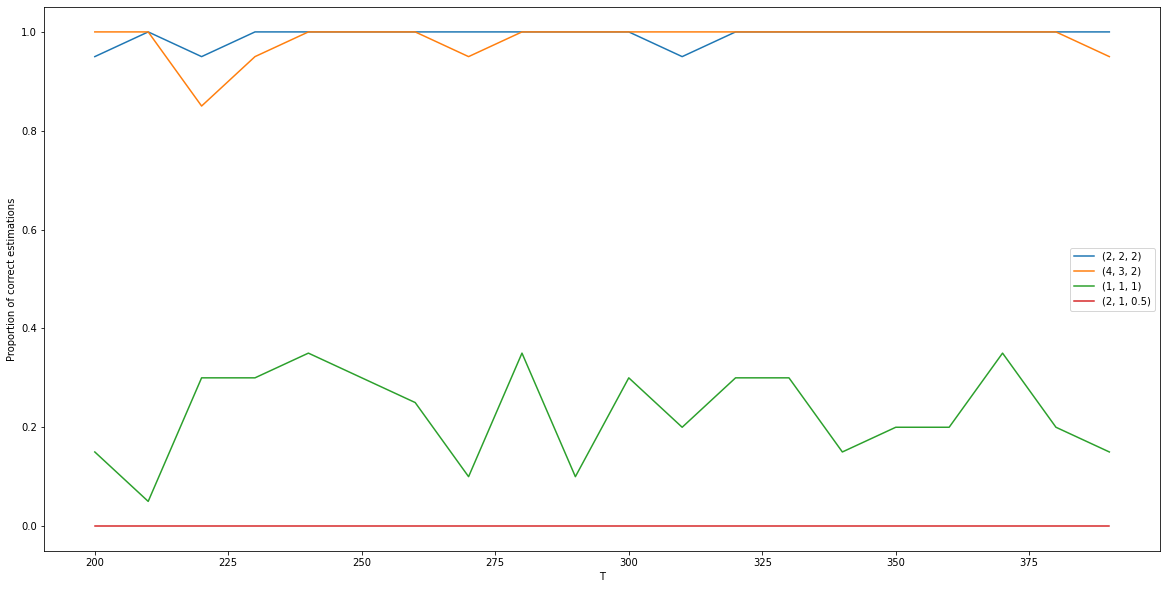

In [ ]:
#we want to estimate the consistency of the multilinear ranks estimator
#we will use the ridge-type ratio estimator, as in the paper
#Theorem 3 in the paper says that the estimator is consistent
#so as T increases, the probability of being correct tends to 1

n_replications = 20

T_list = np.arange(200, 400, 10)
proportions = np.zeros((4, T_list.shape[0]))


for i, T in enumerate(T_list):
    c = np.sqrt(N*P*np.log(T)/(10*T))
    print(T)
    for j, A in enumerate(A_list):
        for n in range(n_replications):
            #we generate the data
            x, y = var_generate(A, T=T)
            #we estimate the transition matrix
            A_hat = initial_estimator(x, y, lambd=1, max_iter=1000)

            tensor = inv_matricization(A_hat, N, N, P)
            #we estimate the multilinear ranks
            ranks = multilinear_ranks_estimator(tensor, c)
            #we check if the estimator is correct
            if ranks == [3, 3, 3]:
                proportions[j, i] += 1/n_replications


#plot the proportion of correct estimations
plt.figure(figsize=(20, 10))
plt.plot(T_list, proportions[0, :], label='(2, 2, 2)')
plt.plot(T_list, proportions[1, :], label='(4, 3, 2)')
plt.plot(T_list, proportions[2, :], label='(1, 1, 1)')
plt.plot(T_list, proportions[3, :], label='(2, 1, 0.5)')
plt.legend()
plt.xlabel('T')
plt.ylabel('Proportion of correct estimations')
plt.show()

# Algorithm for the estimator A_MLR

In [ ]:
def alternating_squares_MLR(y,x,X,A_0,ranks, resolution='SGD', max_iter=100,sgd_steps=100):
    """
    Implementation of the first algorithm in the paper.

    Parameters
    ----------
    y : torch 2d tensor
        (T, N) dimensional tensor containing the time series samples

    x : torch 2d tensor
        (T, N*P) dimensional tensor containing the P previous samples concatenated

    A_0 : tensor
        initialization

    ranks : numpy array
        length of 3, contains the ranks of the tensor

    resolution : string
        type of resolution for the updates, closed form or gradient descent

    max_iter, sgd_steps : int
        number of steps in the optimization process

    Returns
    -------
        A: estimated tensor representing the AR process
    """

    T = y.shape[0]
    N = y.shape[1]
    P = x.shape[1] // N
    A = A_0 #shape (N, N, P)

    #get the ranks
    r1, r2, r3 = ranks[0], ranks[1], ranks[2]

    #compute the HOSVD of A

    A1 = matricization(A, 1)
    A2 = matricization(A, 2)
    A3 = matricization(A, 3)
    U1, S1, V1 = torch.linalg.svd(A1)
    U2, S2, V2 = torch.linalg.svd(A2)
    U3, S3, V3 = torch.linalg.svd(A3)

    #compute the core tensor
    G = torch.zeros(r1, r2, r3).to(device)
    for i in range(r1):
        for j in range(r2):
            for k in range(r3):
                G[i, j, k] = S1[i] * S2[j] * S3[k]

    #compute the matricization of G
    G1 = matricization(G, 1)

    #compute the factor matrices
    U1 = U1[:, :r1]
    U2 = U2[:, :r2]
    U3 = U3[:, :r3]


    for k in range(max_iter):

        #update U1

        if resolution == 'SGD':
          H = torch.kron(U3.contiguous(), U2.contiguous()) @ G1.T
          def loss1(U):
            res = 0
            for t in range(T):
                xt = x[t]
                At = torch.kron(xt.T @ H , torch.eye(N).to(device))
                res += torch.norm(y[t] - At @ U)**2
            return res

          #we use SGD instead of a closed form update
          U = U1.T.reshape(-1).clone().requires_grad_(True)

          optimizer = torch.optim.Adam([U], lr=0.01)
          for _ in range(sgd_steps):
              optimizer.zero_grad()
              loss1(U).backward()
              optimizer.step()

          U1 = U.clone().reshape(r1, N).T.detach()

        else:
          Y = torch.zeros(N*r1).to(device)
          A = torch.zeros(N*r1, N*r1).to(device)
          H = torch.kron(U3.contiguous(), U2.contiguous()) @ G1.T
          for t in range(T):
              xt = x[t]
              At = torch.kron(xt.T @ H , torch.eye(N).to(device))
              Y += At.T @ y[t]
              A += At.T @ At
          if torch.linalg.det(A) == 0:
              A += 1e-2 * torch.eye(N*r1).to(device)
          U1 = torch.linalg.solve(A, Y).reshape(N, r1)

        #update U2

        if resolution == 'SGD':
          H = U1 @ G1
          def loss2(U):
            res = 0
            for t in range(T):
              Xt = X[t]
              At = H @ torch.kron((Xt @ U3).T.contiguous(), torch.eye(r2).to(device))
              res += torch.norm(y[t] - At @ U)**2
            return res

          #we use SGD instead of a closed form update
          U = U2.T.reshape(-1).clone().requires_grad_(True)

          optimizer = torch.optim.Adam([U], lr=0.01)
          for _ in range(sgd_steps):
              optimizer.zero_grad()
              loss2(U).backward(retain_graph=True)
              optimizer.step()

          U2 = U.clone().reshape(r2, N).T.detach()

        else:
          Y = torch.zeros(N*r2).to(device)
          A = torch.zeros(N*r2, N*r2).to(device)
          H = U1 @ G1
          for t in range(T):
              Xt = X[t]
              At = H @ torch.kron((Xt @ U3).T.contiguous(), torch.eye(r2).to(device))
              Y += At.T @ y[t]
              A += At.T @ At
          if torch.linalg.det(A) == 0:
              A += 1e-2 * torch.eye(N*r2).to(device)
          U2 = torch.linalg.solve(A, Y).reshape(r2, N).T

        #update U3

        if resolution == 'SGD':
          H = U1 @ G1
          def loss3(U):
            res = 0
            for t in range(T):
              Xt = X[t]
              At = H @ torch.kron(torch.eye(r3).to(device), (U2.T @ Xt))
              res += torch.norm(y[t] - At @ U)**2
            return res

          #we use SGD instead of a closed form update
          U = U3.T.reshape(-1).clone().requires_grad_(True)

          optimizer = torch.optim.Adam([U], lr=0.01)
          for _ in range(sgd_steps):
              optimizer.zero_grad()
              loss3(U).backward(retain_graph=True)
              optimizer.step()

          U3 = U.clone().reshape(r3, P).T.detach()


        else:
          Y = torch.zeros(P*r3).to(device)
          A = torch.zeros(P*r3, P*r3).to(device)
          H = U1 @ G1
          for t in range(T):
              Xt = X[t]
              At = H @ torch.kron(torch.eye(r3).to(device), (U2.T @ Xt))
              Y += At.T @ y[t]
              A += At.T @ At
          if torch.linalg.det(A) == 0:
              A += 1e-2 * torch.eye(P*r3).to(device) #numerical stability
          U3 = torch.linalg.solve(A, Y).reshape(P, r3)

        #update G1

        if resolution == 'SGD':
          H = U1 @ G1
          def loss4(U):
            res = 0
            for t in range(T):
              xt = x[t]
              At = torch.kron((torch.kron(U3.contiguous(), U2.contiguous()).T @ xt).T.contiguous(), U1.contiguous())
              res += torch.norm(y[t] - At @ U)**2
            return res

          #we use SGD instead of a closed form update
          U = G1.T.reshape(-1).clone().requires_grad_(True)

          optimizer = torch.optim.Adam([U], lr=0.01)
          for _ in range(sgd_steps):
              optimizer.zero_grad()
              loss4(U).backward(retain_graph=True)
              optimizer.step()

          G1 = U.clone().reshape(r2*r3, r1).T.detach()

        else:
          Y = torch.zeros(r1*r2*r3).to(device)
          A = torch.zeros(r1*r2*r3, r1*r2*r3).to(device)
          for t in range(T):
              xt = x[t]
              At = torch.kron((torch.kron(U3.contiguous(), U2.contiguous()).T @ xt).T.contiguous(), U1.contiguous())
              Y += At.T @ y[t]
              A += At.T @ At
          if torch.linalg.det(A) == 0:
              A += 1e-2 * torch.eye(r1*r2*r3).to(device)
          G1 = torch.linalg.solve(A, Y).reshape(r1, r2 * r3)

    #return A, whose tucker decomposition is U1, U2, U3, G
    G = inv_matricization(G1, r1, r2, r3)

    #print(G.shape, G1.shape, U1.shape, U2.shape, U3.shape)
    #mode 1 product of U1 and G
    A1 = torch.einsum('ij, jkl -> ikl', U1, G)
    #mode 2 product of A1 and U2
    A2 = torch.einsum('ij, kjl -> kil', U2, A1)
    #mode 3 product of A2 and U3
    A = torch.einsum('ij, klj -> kli', U3, A2)

    return A_0

# OLS Estimator

In [ ]:
def ols_estimator(y,x):
    """
    Implementation of the ordinary least squares estimator.

    Parameters
    ----------
    y : torch tensor
        samples of the time series
    x : torch tensor
        concatenation of the P previous samples along an axis

    Returns
    -------
        A: estimated tensor for the AR process
    """

    T = y.shape[0]
    N = y.shape[1]
    P = x.shape[1] // N

    A = torch.zeros(N*P, N*P)
    Y = torch.zeros(N, N*P)
    for t in range(T):
        yt = y[t]
        xt = x[t]
        Y += torch.outer(yt, xt)
        A += torch.outer(xt, xt)
    #if torch.linalg.det(A) == 0:
        #A += 1e-2 * torch.eye(N*P) #for numerical stability
    return torch.linalg.solve(A, Y, left=False)

# RRR Estimator

In [ ]:
def rrr_estimator(y, x, k):
    """
    Implementation of the reduced rank regression estimator.

    Parameters
    ----------
    y : torch tensor
        time series samples
    x : torch tensor
        concatenation of the P previous samples
    k : int
        rank

    Returns
    -------
        A: estimated tensor representing the AR process
    """

    T = y.shape[0]
    Y = y.T
    X = x.T

    U, S, V = torch.svd(X)
    U_k = U[:, :k]
    S_k = torch.diag(S[:k])
    V_k = V[:, :k]
    A_k = Y @ V_k @ S_k.inverse() @ U_k.T
    return A_k

# Real Data :

In [ ]:
#%matplotlib inline

#read the data
df = pd.read_csv("AirQualityUCI.csv", parse_dates=[['Date', 'Time']], delimiter=';')
df = df.drop(['Date_Time'], axis=1)
df = df.drop(['Unnamed: 15'], axis=1)
df = df.drop(['Unnamed: 16'], axis=1)

#changing commas into floating points
def f(x):
  return x.replace(',', '.', regex=True).astype(float)
df = df.apply(f)
df = df.apply(pd.to_numeric)
df = df.dropna()

#check the dtypes
print(df.dtypes)

#missing value treatment
cols = df.columns
for j in cols:
    for i in range(0,len(df)):
       if df[j][i] == -200:
           df[j][i] = df[j][i-1]

df.describe()

CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,2.082195,1102.730362,270.496740,10.190392,942.548253,240.731217,832.742225,109.414877,1453.014535,1030.511916,18.317356,48.817431,1.017382
std,1.469801,219.588101,73.306853,7.565771,269.581368,206.618453,255.709423,47.221662,347.434084,410.916759,8.821883,17.354326,0.404829
min,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.000000,938.000000,275.000000,4.400000,733.000000,97.000000,655.000000,73.000000,1228.000000,726.000000,11.900000,35.400000,0.726200
50%,1.700000,1062.000000,275.000000,8.300000,911.000000,174.000000,807.000000,102.000000,1460.000000,964.000000,17.600000,48.900000,0.987500
75%,2.800000,1237.000000,275.000000,14.000000,1117.000000,318.000000,968.000000,137.000000,1677.000000,1287.000000,24.300000,61.900000,1.306700
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [ ]:
#stationarity check
from statsmodels.tsa.vector_ar.vecm import coint_johansen

#the test only works for 12 variables and the dataset has 13 of them so we drop one randomly, and we check the eigenvalues
johan_test_temp = df.drop([ 'CO(GT)'], axis=1)
coint_johansen(johan_test_temp,-1,1).eig

array([1.75510896e-01, 1.52389933e-01, 1.15120416e-01, 1.04126281e-01,
       9.29485509e-02, 6.89397159e-02, 5.77070988e-02, 3.43554214e-02,
       3.05980659e-02, 1.18697142e-02, 2.46766099e-03, 7.09584856e-05])

There are some eigenvalues significantly different from zero, so the data might be non stationary.

# Data analysis

Data Set Information:

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value.
This dataset can be used exclusively for research purposes. Commercial purposes are fully excluded.

In [ ]:
#setting the order
P = 7

In [ ]:
#transforming the dataframe into a tensor containing the samples
y = torch.tensor(df.values)

#only keeping one value per day
y = y[::24]

#constructing the tensor x, of the lagged samples
T, N = y.shape
x = torch.zeros(T-P, N*P).float()
for t in range(P, T):
    #we concatenate the last P samples
    x[t-P] = torch.cat([y[t-i] for i in range(1, P+1)], dim=0)

#we can now discard the first P samples, only used for initialization
y = y[P:].float()
T = T-P

#for the MLR
X = x.reshape(T, N, P).float()

#checking the shapes
print(y.shape, x.shape)

torch.Size([383, 13]) torch.Size([383, 91])


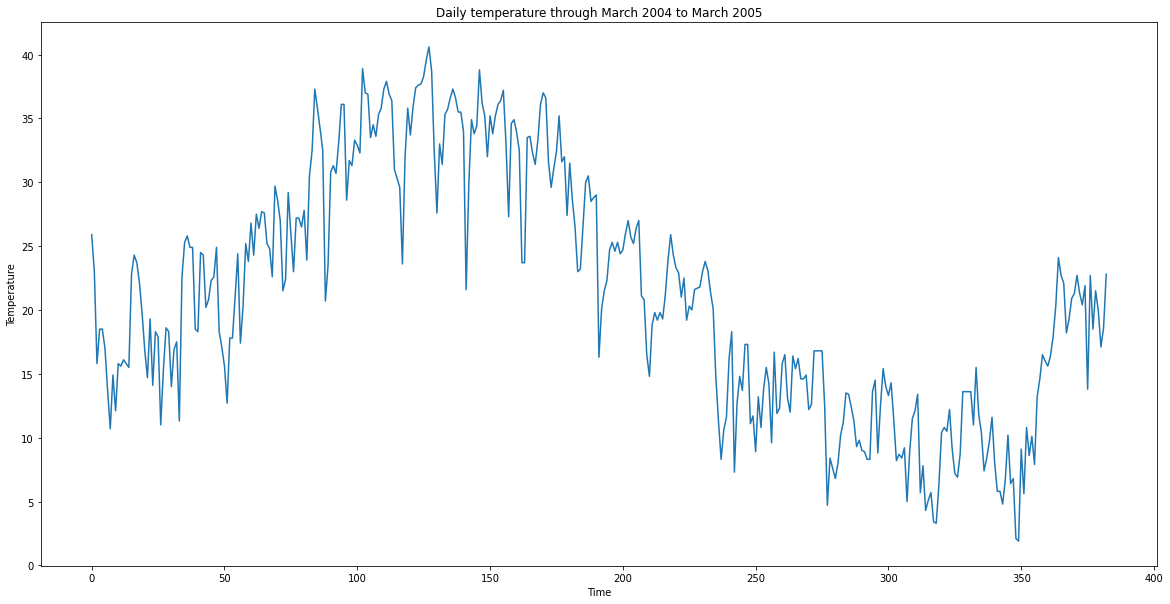

In [ ]:
#plotting the temperature over the whole time horizon
plt.figure(figsize=(20, 10))
plt.plot(y[:, -3])
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Daily temperature through March 2004 to March 2005')
plt.show()

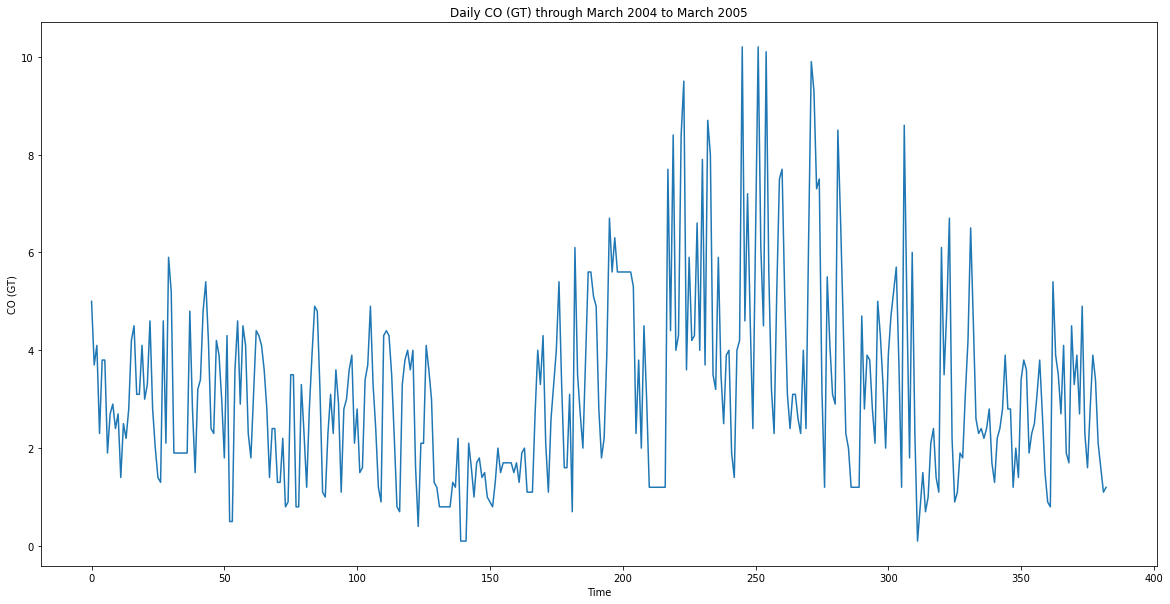

In [ ]:
#plotting the CO (GT) over the whole time horizon
plt.figure(figsize=(20, 10))
plt.plot(y[:, 0])
plt.xlabel('Time')
plt.ylabel('CO (GT)')
plt.title('Daily CO (GT) through March 2004 to March 2005')
plt.show()

# Testing on real data

In [ ]:
#initial estimator
A_0 = initial_estimator(x, y, lambd=1, max_iter=1000)
tensor = inv_matricization(A_0, N, N, P)

#we estimate the multilinear ranks
ranks = multilinear_ranks_estimator(tensor, c)
c = np.sqrt(N*P*np.log(T)/(10*T))

In [ ]:
A_mlr = alternating_squares_MLR(y, x, X, tensor, ranks, resolution='other')

9 12 5


<ipython-input-23-78a4f058afeb>:90: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  At = torch.kron(xt.T @ H , torch.eye(N).to(device))


In [ ]:
A_ols = ols_estimator(y, x)

In [ ]:
A_rrr = rrr_estimator(y, x, ranks[2])

#Using the estimators for forecasting

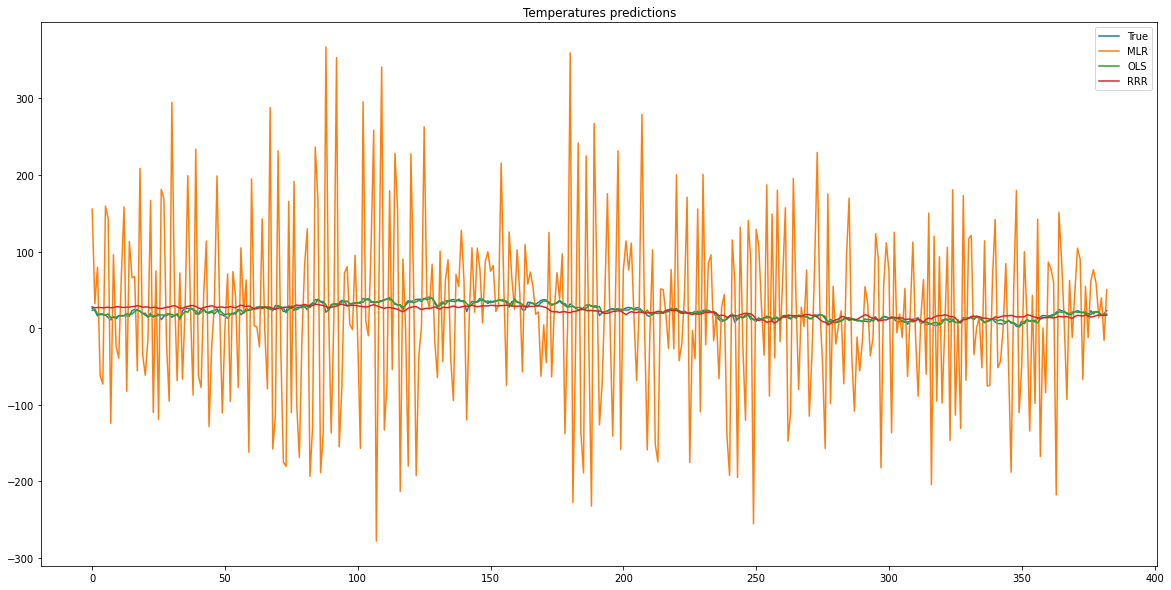

In [ ]:
A_mlr1 = matricization(A_mlr, 1)
A_ols1 = A_ols
A_rrr1 = A_rrr

mlr_preds = x @ A_mlr1.T
ols_preds = x @ A_ols1.T
rrr_preds = x @ A_rrr1.T

#plot the temperatures predictions on the same plot with the true values of y
plt.figure(figsize=(20, 10))
plt.plot(y[:, -3], label='True')
plt.plot(mlr_preds[:, -3], label='MLR')
plt.plot(ols_preds[:, -3], label='OLS')
plt.plot(rrr_preds[:, -3], label='RRR')
plt.legend()
plt.title('Temperatures predictions')
plt.show()

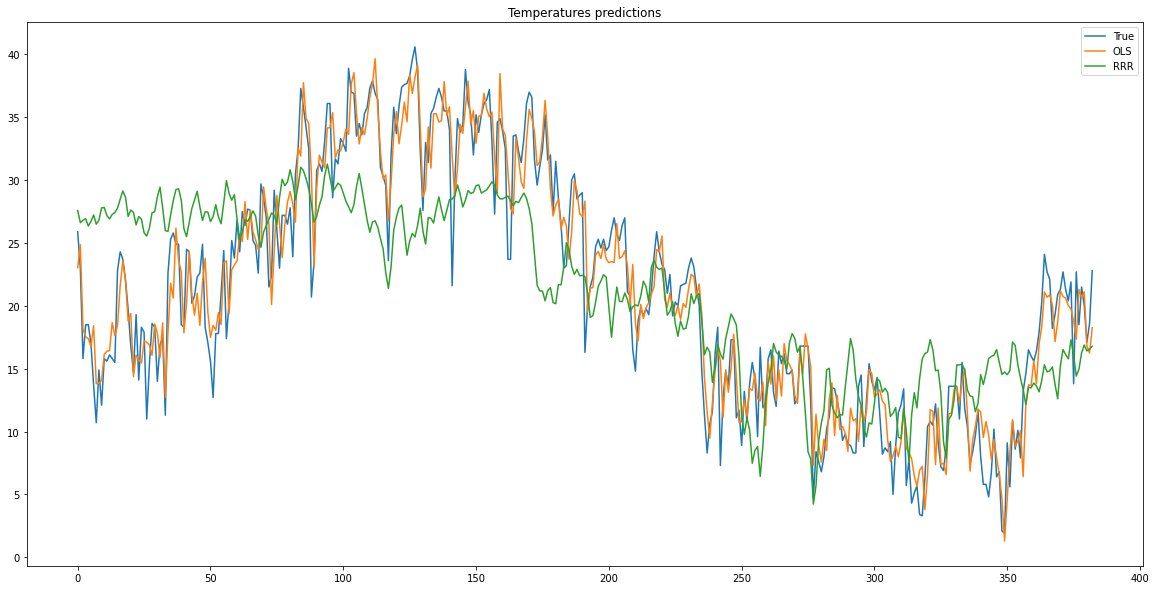

In [ ]:
#same plot without MLR because the implementation is faulty
plt.figure(figsize=(20, 10))
plt.plot(y[:, -3], label='True')
plt.plot(ols_preds[:, -3], label='OLS')
plt.plot(rrr_preds[:, -3], label='RRR')
plt.legend()
plt.title('Temperatures predictions')
plt.show()

# Second algorithm

In [ ]:
def admm_subroutine(y, X, B, N, r, T, kappa=1, lambd=1, max_iter1=100, max_iter2=100, sgd_steps=10):
    """
    Subroutine in algorithm 2 for the optimization while preserving the orthogonality.

    Parameters
    ----------
    y : torch tensor
        time series samples
    X : torch tensor
        concatenation of the time series samples
    B : torch tensor
        initialization
    N : int
        dimension of the problem
    r : int
        rank
    T : int
        length of the time series
    kappa : float
        regularization parmater
    lambd : float
        regularization parameter
    max_iter1, max_iter2, sgd_steps : int
        length of the loop for the optimization processes

    Returns
    -------
        B: argmin of the subroutine problem
    """

    #y is a NT x 1 vector
    #X is a NT x NPT matrix

    #initialization
    W = B.clone()
    M = torch.zeros(N * r)
    for k in range(max_iter1):

        #update B
        #using the SOC method, cited in the paper
        I = B.clone()
        J = B.clone()
        K = B.clone()
        def loss(I):
                return (1/T)*torch.norm(y - X @ I)**2 + kappa * torch.norm(I-W+M)**2 + 0.5*torch.norm(I-J+K)**2

        for j in range(max_iter2):

            #update I
            #we do gradient descent for this one
            #Adam optimizer
            optimizer = torch.optim.Adam([I], lr=0.01)
            for _ in range(sgd_steps):
                optimizer.zero_grad()
                loss(I).backward()
                optimizer.step()

            #update J
            Y = I + K
            U, D, V = torch.linalg.svd(Y)
            J = U @ torch.eye(N, r) @ V.T

            #update K
            K = K + I - J
        B = I


        #update W
        #we have to solve a least squares problem with a l1 penalty
        #we use ista

        def soft_threshold(x, lambd):
            return torch.sign(x) * torch.clamp(torch.abs(x) - lambd, min=0)

        def ista(b, lambd, max_iter=100):
            x = torch.zeros(b.shape)
            L = b.shape[0]
            for i in range(max_iter):
                x = soft_threshold(x + (b - x) / L, lmbda / L)
            return x

        W = ista(B+M, lambd/kappa, max_iter=100)


        #update M
        M = M + B - W

    return B

# Algorithm for the estimator A_SHORR

In [ ]:
def ADMM_SHORR(y,x,X,A_0,ranks,max_iter=100, lambd=1, rho1=1, rho2=1, rho3=1):
    """
    Implementation of algorithm 2 of the paper.

    Parameters
    ----------
    y : torch tensor
        time series samples
    x : torch tensor
        concatenation of the P previous samples
    X : torch

    A_0 : torch tensor
        initialization
    ranks : numpy array
        ranks for the tensor, of lenght 3
    max_iter : int
        number of steps in the optimization process
    lambd : float
        regularization parameter
    rho1, rho2, rho3 : float
        regularization parameters

    Returns
    -------
        A: estimated tensor representing the AR process
    """

    T = y.shape[0]
    N = y.shape[1]
    P = x.shape[1] // N
    A = A_0 #shape (N, N, P)

    #get the ranks
    r1, r2, r3 = ranks[0], ranks[1], ranks[2]

    #compute the HOSVD of A
    A1 = matricization(A, 1)
    A2 = matricization(A, 2)
    A3 = matricization(A, 3)
    U1, S1, V1 = torch.linalg.svd(A1)
    U2, S2, V2 = torch.linalg.svd(A2)
    U3, S3, V3 = torch.linalg.svd(A3)

    #compute the core tensor
    G = torch.zeros(r1, r2, r3)
    for i in range(r1):
        for j in range(r2):
            for k in range(r3):
                G[i, j, k] = S1[i] * S2[j] * S3[k]

    #compute the matricizations of G
    G_mats = [matricization(G, 1), matricization(G, 2), matricization(G, 3)]

    #compute the factor matrices
    U1 = U1[:, :r1]
    U2 = U2[:, :r2]
    U3 = U3[:, :r3]

    for k in range(max_iter):

        #update U1
        H = torch.kron(U3.contiguous(), U2.contiguous()) @ G_mats[0].T
        X1 = torch.zeros(N*T, N*r1)
        for t in range(T):
            xt = x[t]
            At = torch.kron(xt.T @ H , torch.eye(N))
            X1[t*N:(t+1)*N, :] = At
        U1 = admm_subroutine(y.reshape(-1), X1, U1.T.reshape(-1), N, r1, T, kappa=1, lambd=lambd*torch.norm(U2, ord=1)*torch.norm(U3, ord=1), max_iter1=100, max_iter2=100, sgd_steps=10)

        #update U2
        H = U1 @ G_mats[0]
        X2 = torch.zeros(N*T, N*r2)
        for t in range(T):
            Xt = X[t]
            At = H @ torch.kron((Xt @ U3).T.contiguous(), torch.eye(r2))
            X2[t*N:(t+1)*N, :] = At
        U2 = admm_subroutine(y.reshape(-1), X2, U2.T.reshape(-1), N, r2, T, kappa=1, lambd=lambd*torch.norm(U1, ord=1)*torch.norm(U3, ord=1), max_iter1=100, max_iter2=100, sgd_steps=10)

        #update U3
        H = U1 @ G_mats[0]
        X3 = torch.zeros(N*T, N*r3)
        for t in range(T):
            Xt = X[t]
            At = H @ torch.kron(torch.eye(r3), (U2.T @ Xt))
            X3[t*N:(t+1)*N, :] = At
        U3 = admm_subroutine(y.reshape(-1), X3, U3.T.reshape(-1), N, r3, T, kappa=1, lambd=lambd*torch.norm(U1, ord=1)*torch.norm(U2, ord=1), max_iter1=100, max_iter2=100, sgd_steps=10)

        #update G
        #we will use SGD on a square loss
        def loss(G):
            return torch.sum((y - X @ (U1 @ G @ U2.T @ U3.T))**2)



    #return A, whose tucker decomposition is U1, U2, U3, G
    G = inv_matricization(G1, r1, r2, r3)

    #mode 1 product of U1 and G
    A1 = torch.einsum('ij, jkl -> ikl', U1, G)
    #mode 2 product of A1 and U2
    A2 = torch.einsum('ij, kjl -> kil', U2, A1)
    #mode 3 product of A2 and U3
    A = torch.einsum('ij, klj -> kli', U3, A2)

    return A